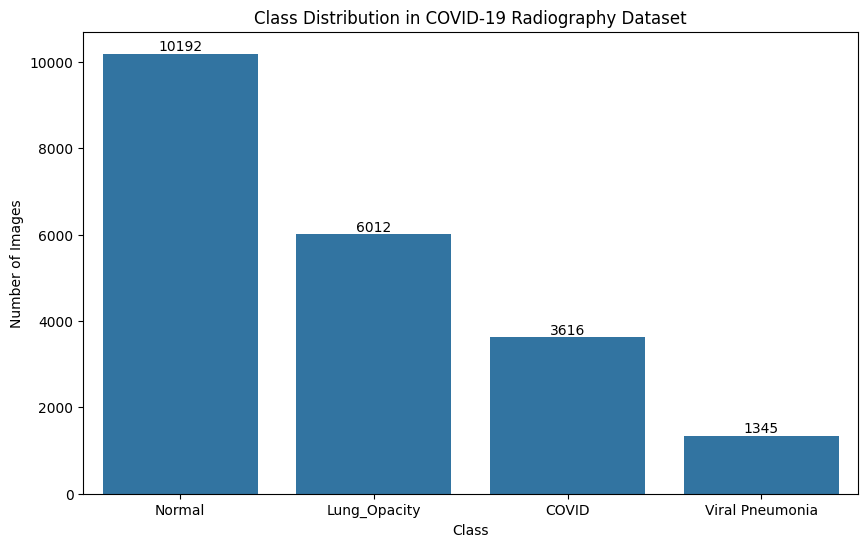

In [15]:
# Load the metadata, and check the class distribution in the dataset

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_base_dir = './covid19-radiography-dataset/'
metadata = pd.read_csv(os.path.join(data_base_dir, 'metadata.csv'))

label_counts = metadata['label'].value_counts()
class_distribution = pd.DataFrame(list(label_counts.items()), columns=['Class', 'Number of Images'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Number of Images', data=class_distribution)
plt.title('Class Distribution in COVID-19 Radiography Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')

# add counts to each bar
for i in range(class_distribution.shape[0]):
    count = class_distribution.iloc[i, 1]
    plt.text(i, count, count, ha='center', va='bottom')

plt.show()

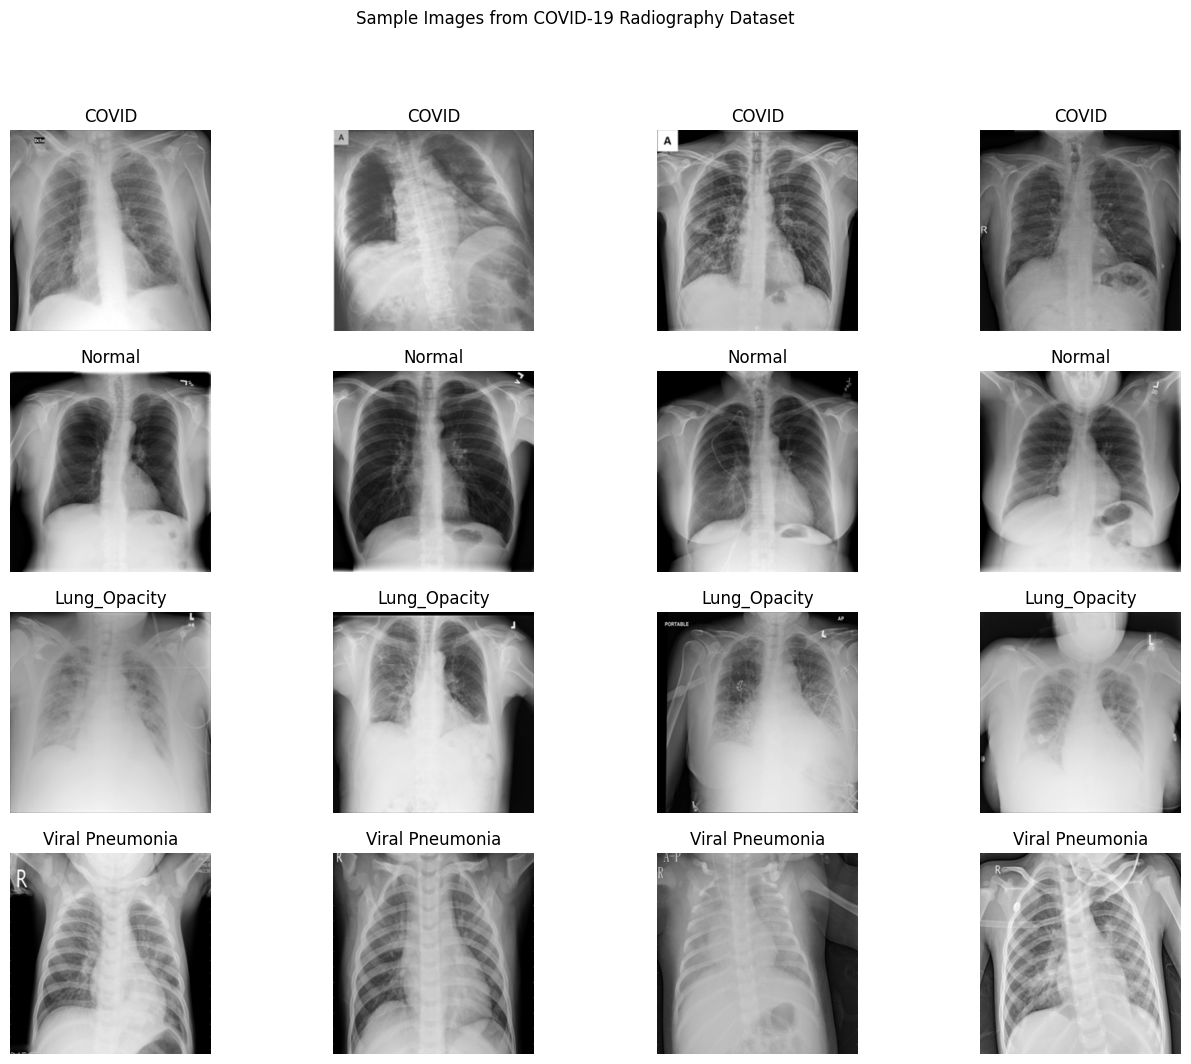

In [16]:
# Display sample images, randomly selected from the dataset

import cv2
import random
import os

radiography_dataset_path = os.path.join(data_base_dir, 'COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset')


def image_filename(image_id: int) -> str:
    """
        Return the filename of the image with the given image_id,
        using the relative base directory path.

        Args:
            image_id: The unique identifier of the image in the metadata

        Returns:
            The relative filename of the image
    """
    return os.path.join(radiography_dataset_path, metadata.loc[image_id, 'label'], metadata.loc[image_id, 'file_name'])


plt.figure(figsize=(16, 12))
# show 4 normal, 4 covid, 4 lung opacity, 4 viral pneumonia images
for i in ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']:
    class_images = metadata[metadata['label'] == i]
    random_indices = random.sample(range(class_images.shape[0]), 4)
    for j, idx in enumerate(random_indices):
        plt.subplot(4, 4, 4 * ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia'].index(i) + j + 1)
        image = cv2.imread(image_filename(class_images.index[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.title(i)
        plt.axis('off')

plt.suptitle('Sample Images from COVID-19 Radiography Dataset')
plt.show()

In [17]:
# Preprocess the images, ensuring all dimensions are the same (224x224)
# and check the class distribution again.
# Moving forwards we build a new dataframe to store the preprocessed images
# and fit the machine learning models to this new dataset.


def encode_labels(label: str) -> int:
    """
        Return the integer label for the given string label.

        Args:
            label: The string label

        Returns:
            The integer label
    """
    match label.casefold():
        case 'normal':
            return 0
        case 'covid':
            return 1
        case "lung_opacity":
            return 2
        case "viral pneumonia":
            return 3
        case _:
            raise ValueError(f'Invalid label: {label}')


def decode_labels(label: int) -> str:
    """
        Return the string label for the given integer label.

        Args:
            label: The integer label

        Returns:
            The string label
    """
    match label:
        case 0:
            return 'Normal'
        case 1:
            return 'COVID'
        case 2:
            return 'Lung_Opacity'
        case 3:
            return 'Viral Pneumonia'
        case _:
            raise ValueError(f'Invalid label: {label}')


df = pd.DataFrame(columns=['image', 'label'])

for i in metadata.index:
    filename = image_filename(i)
    label = metadata.loc[i, 'label']
    image = cv2.imread(filename)
    image = cv2.resize(image, (224, 224))
    image_flattened = image.flatten().astype(np.float32)

    label = encode_labels(label)
    df.loc[i] = {'image': image, 'label': label}

print(df.head())
print(df.shape)
print(df['label'].value_counts())

                                               image  label
0  [[[145, 145, 145], [18, 18, 18], [0, 0, 0], [0...      1
1  [[[134, 134, 134], [131, 131, 131], [129, 129,...      1
2  [[[49, 49, 49], [4, 4, 4], [0, 0, 0], [0, 0, 0...      1
3  [[[139, 139, 139], [139, 139, 139], [139, 139,...      1
4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      1
(21165, 2)
label
0    10192
2     6012
1     3616
3     1345
Name: count, dtype: int64


In [18]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np

# Splitting the data into train and test sets
train, test = train_test_split(df, test_size=0.2, stratify=df['label'])

# Splitting the train data into train and validation sets
train, val = train_test_split(train, test_size=0.2, stratify=train['label'])

# Applying SMOTE to the training data
smote = SMOTE()
X_train_flattened = np.array(train['image'].tolist()).reshape(train.shape[0], -1)
y_train = train['label'].values

X_train_resampled, y_train = smote.fit_resample(X_train_flattened, y_train)

# Reshape the resampled data back to the original shape
X_train = X_train_resampled.reshape(X_train_resampled.shape[0], 224, 224, 3)

# Prepare the testing data
X_test = np.array(test['image'].tolist(), dtype=np.float32).reshape(-1, 224, 224, 3)
y_test = test['label'].values

# Prepare the validation data
X_val = np.array(val['image'].tolist(), dtype=np.float32).reshape(-1, 224, 224, 3)
y_val = val['label'].values

print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

print("Train set rebalanced class distribution:", pd.Series(y_train).value_counts())
print("Validation set class distribution:", pd.Series(y_val).value_counts())
print("Test set class distribution:", pd.Series(y_test).value_counts())

Train set shape: (26092, 224, 224, 3) (26092,)
Validation set shape: (3387, 224, 224, 3) (3387,)
Test set shape: (4233, 224, 224, 3) (4233,)
Train set rebalanced class distribution: 0    6523
2    6523
1    6523
3    6523
Name: count, dtype: int64
Validation set class distribution: 0    1631
2     962
1     579
3     215
Name: count, dtype: int64
Test set class distribution: 0    2038
2    1203
1     723
3     269
Name: count, dtype: int64


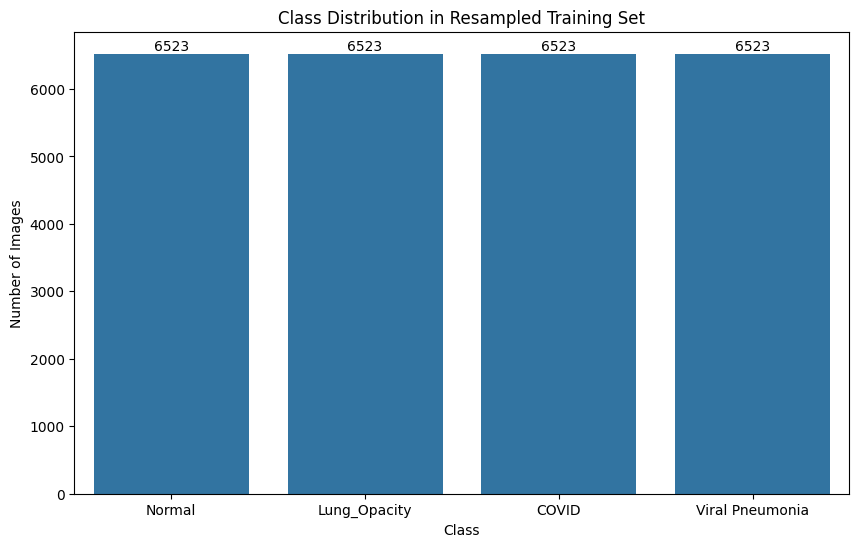

In [19]:
# show class distribution in resampled training set

data = pd.DataFrame(columns=['label'])
data['label'] = y_train
data['label'] = data['label'].apply(decode_labels)

plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=data)
plt.title('Class Distribution in Resampled Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')

for i in range(4):
    count = pd.Series(y_train).value_counts().iloc[i]
    plt.text(i, count, count, ha='center', va='bottom')

plt.show()


In [20]:
import tensorflow as tf

num_classes = len(np.unique(y_train))  # Number of classes

y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val_categorical = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# Check shapes
print(y_train_categorical.shape, y_val_categorical.shape, y_test_categorical.shape)

(26092, 4) (3387, 4) (4233, 4)


In [21]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model_resnet50 = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False``

# Compile the model
model_resnet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_resnet50 = model_resnet50.fit(
    X_train, y_train_categorical,
    validation_data=(X_val, y_val_categorical),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 551s 671ms/step - accuracy: 0.7676 - loss: 0.7401 - val_accuracy: 0.8547 - val_loss: 0.3930
Epoch 2/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 545s 668ms/step - accuracy: 0.8516 - loss: 0.3801 - val_accuracy: 0.8683 - val_loss: 0.3436
Epoch 3/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 558s 684ms/step - accuracy: 0.8654 - loss: 0.3403 - val_accuracy: 0.8928 - val_loss: 0.3004
Epoch 4/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 545s 668ms/step - accuracy: 0.8762 - loss: 0.3188 - val_accuracy: 0.8875 - val_loss: 0.2998
Epoch 5/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 550s 674ms/step - accuracy: 0.8849 - loss: 0.3055 - val_accuracy: 0.8816 - val_loss: 0.3375
Epoch 6/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 561s 688ms/step - accuracy: 0.8830 - loss: 0.2945 - val_accuracy: 0.8987 - val_loss: 0.2773
Epoch 7/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 570s 698ms/step - accuracy: 0.8927 - loss: 0.2804 - val_accuracy: 0.8946 - val_loss: 0.2853
Epoch 8/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 571s 700ms/step - accuracy: 0.8947 -

In [22]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


# Load pre-trained ResNet50 model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model_resnet50v2 = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_resnet50v2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Fit the model with early stopping
history_resnet50v2 = model_resnet50v2.fit(
    X_train, y_train_categorical,  # Training data
    validation_data=(X_val, y_val_categorical),  # Validation data
    epochs=50,  # Maximum number of epochs
    batch_size=32,  # Number of samples per gradient update
    callbacks=[early_stopping]  # Include the EarlyStopping callback
)

Epoch 1/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 522s 637ms/step - accuracy: 0.4068 - loss: 34.7088 - val_accuracy: 0.4727 - val_loss: 1.0641
Epoch 2/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 525s 643ms/step - accuracy: 0.4443 - loss: 1.1846 - val_accuracy: 0.4957 - val_loss: 1.0215
Epoch 3/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 518s 635ms/step - accuracy: 0.4556 - loss: 1.1659 - val_accuracy: 0.5810 - val_loss: 1.1160
Epoch 4/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 519s 636ms/step - accuracy: 0.4663 - loss: 1.1408 - val_accuracy: 0.6242 - val_loss: 1.0605
Epoch 5/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 520s 638ms/step - accuracy: 0.4643 - loss: 1.1262 - val_accuracy: 0.6177 - val_loss: 0.9849
Epoch 6/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 528s 647ms/step - accuracy: 0.4776 - loss: 1.1041 - val_accuracy: 0.6191 - val_loss: 1.0186
Epoch 7/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 527s 645ms/step - accuracy: 0.4826 - loss: 1.1016 - val_accuracy: 0.5908 - val_loss: 1.0343
Epoch 8/50
816/816 ━━━━━━━━━━━━━━━━━━━━ 526s 645ms/step - accuracy: 0.4817 

ResNet50 Model
Train Accuracy: 0.9317032098770142
Validation Accuracy: 0.9117212891578674
Test Accuracy: 0.91046541929245
Loss for ResNet50 Model:  0.2432747185230255

ResNet50V2 Model
Train Accuracy: 0.6364402770996094
Validation Accuracy: 0.6622379422187805
Test Accuracy: 0.6555634140968323
Loss for ResNet50V2 Model:  0.8666603565216064


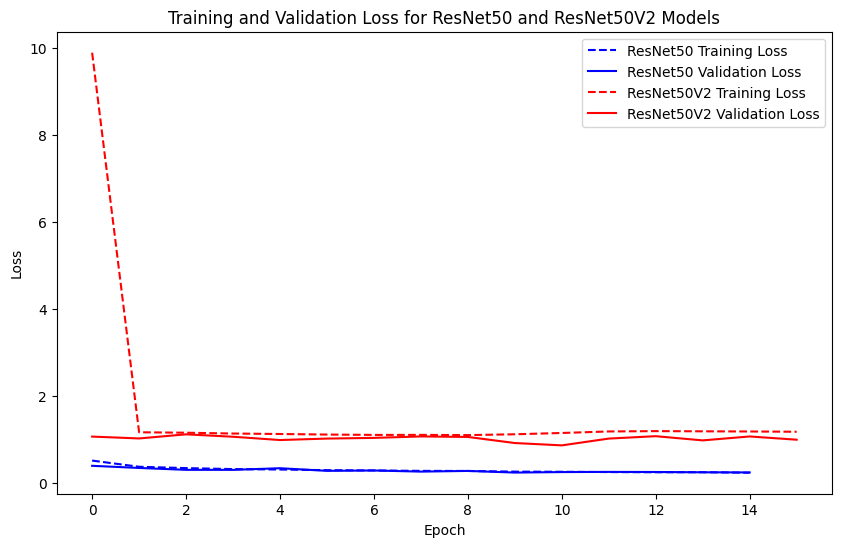

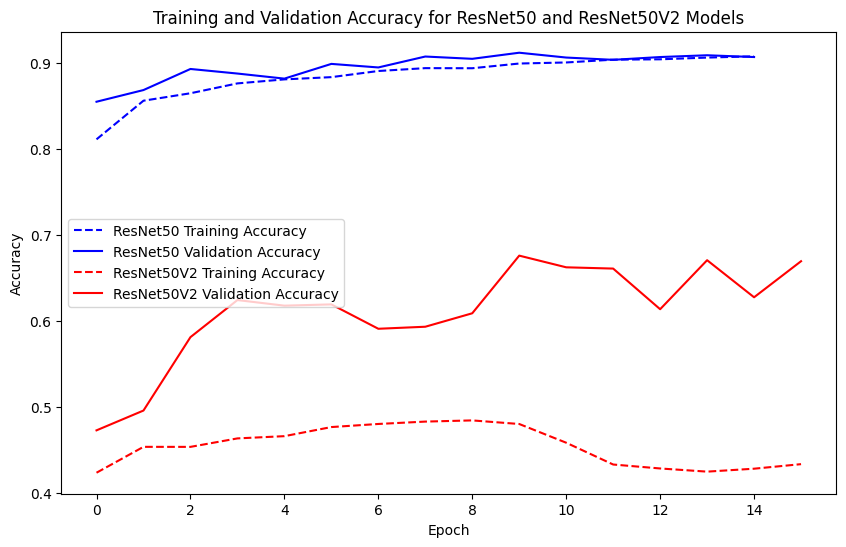

In [36]:
# Accuracy for each model

train_loss_resnet50, train_accuracy_resnet50 = model_resnet50.evaluate(X_train, y_train_categorical, verbose=0)
val_loss_resnet50, val_accuracy_resnet50 = model_resnet50.evaluate(X_val, y_val_categorical, verbose=0)
test_loss_resnet50, test_accuracy_resnet50 = model_resnet50.evaluate(X_test, y_test_categorical, verbose=0)

train_loss_resnet50v2, train_accuracy_resnet50v2 = model_resnet50v2.evaluate(X_train, y_train_categorical, verbose=0)
val_loss_resnet50v2, val_accuracy_resnet50v2 = model_resnet50v2.evaluate(X_val, y_val_categorical, verbose=0)
test_loss_resnet50v2, test_accuracy_resnet50v2 = model_resnet50v2.evaluate(X_test, y_test_categorical, verbose=0)

print("ResNet50 Model")
print("Train Accuracy:", train_accuracy_resnet50)
print("Validation Accuracy:", val_accuracy_resnet50)
print("Test Accuracy:", test_accuracy_resnet50)

print("Loss for ResNet50 Model: ", test_loss_resnet50)

print("\nResNet50V2 Model")
print("Train Accuracy:", train_accuracy_resnet50v2)
print("Validation Accuracy:", val_accuracy_resnet50v2)
print("Test Accuracy:", test_accuracy_resnet50v2)

print("Loss for ResNet50V2 Model: ", test_loss_resnet50v2)


# Plot the training and validation loss

plt.figure(figsize=(10, 6))
plt.plot(history_resnet50.history['loss'], label='ResNet50 Training Loss', color='blue', linestyle='--')
plt.plot(history_resnet50.history['val_loss'], label='ResNet50 Validation Loss', color='blue')
plt.plot(history_resnet50v2.history['loss'], label='ResNet50V2 Training Loss', color='red', linestyle='--')
plt.plot(history_resnet50v2.history['val_loss'], label='ResNet50V2 Validation Loss', color='red')
plt.title('Training and Validation Loss for ResNet50 and ResNet50V2 Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy

plt.figure(figsize=(10, 6))
plt.plot(history_resnet50.history['accuracy'], label='ResNet50 Training Accuracy', color='blue', linestyle='--')
plt.plot(history_resnet50.history['val_accuracy'], label='ResNet50 Validation Accuracy', color='blue')
plt.plot(history_resnet50v2.history['accuracy'], label='ResNet50V2 Training Accuracy', color='red', linestyle='--')
plt.plot(history_resnet50v2.history['val_accuracy'], label='ResNet50V2 Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy for ResNet50 and ResNet50V2 Models')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

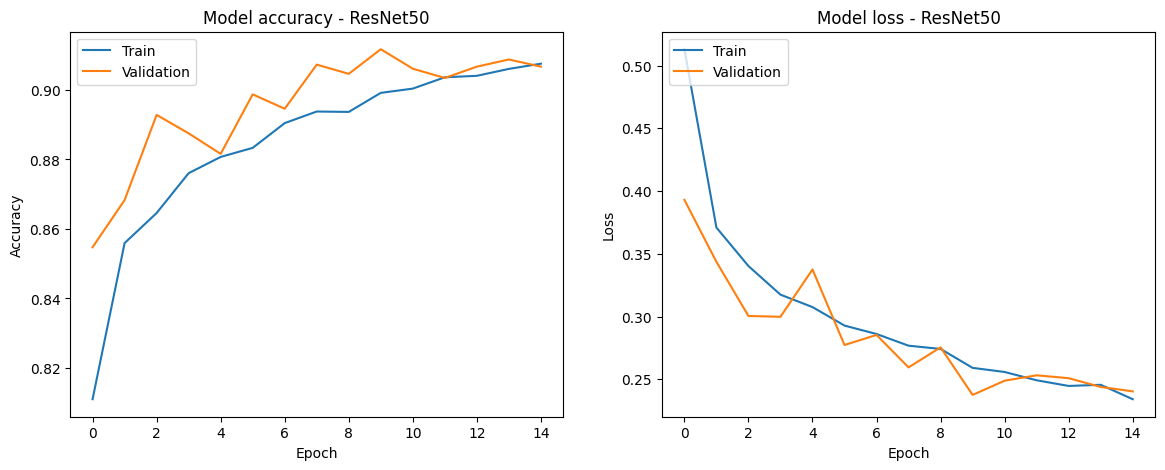

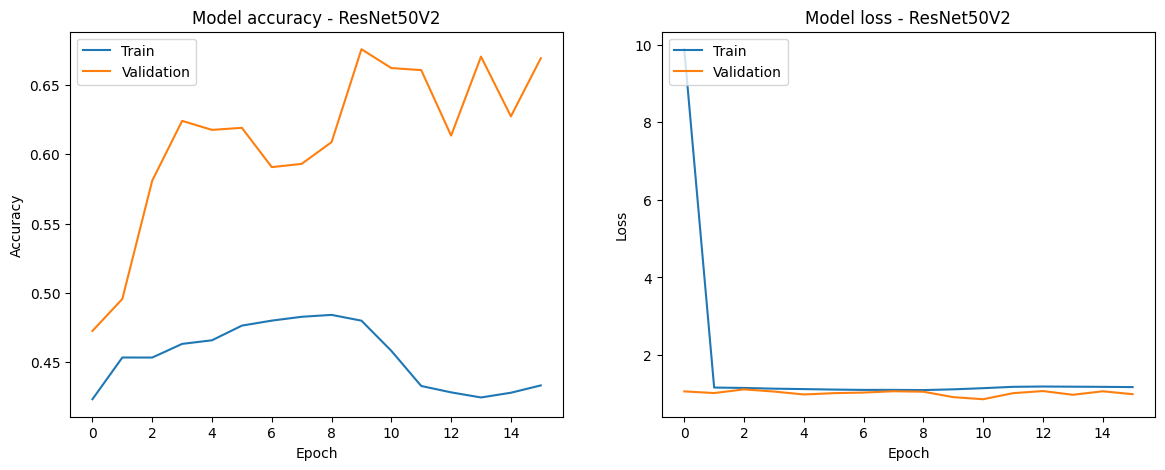

In [23]:
def plot_history(history, model_name):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Plot history for ResNet50
plot_history(history_resnet50, 'ResNet50')

# Plot history for ResNet50V2
plot_history(history_resnet50v2, 'ResNet50V2')

133/133 ━━━━━━━━━━━━━━━━━━━━ 82s 608ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 75s 559ms/step


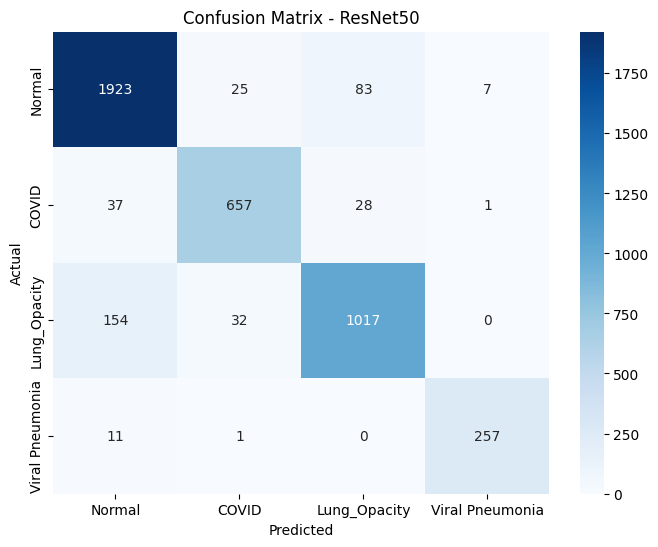

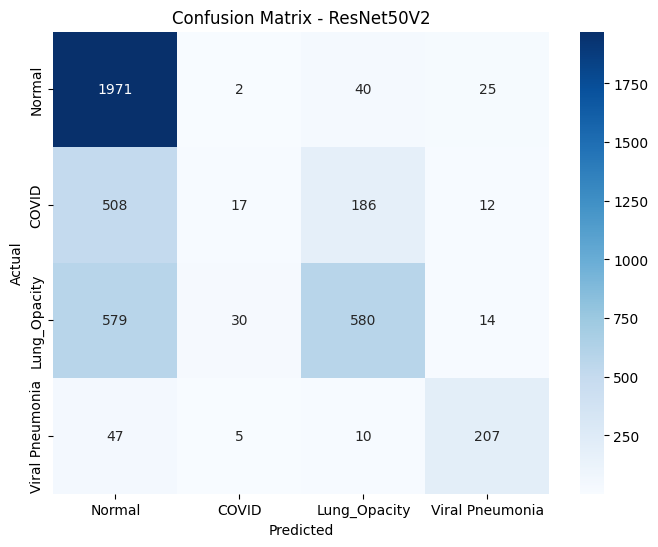

In [25]:
# Confusion matrices for the models

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia'],
                yticklabels=['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Predictions for ResNet50
y_pred_resnet50 = model_resnet50.predict(X_test)
y_pred_resnet50 = np.argmax(y_pred_resnet50, axis=1)

# Predictions for ResNet50V2
y_pred_resnet50v2 = model_resnet50v2.predict(X_test)
y_pred_resnet50v2 = np.argmax(y_pred_resnet50v2, axis=1)

# Plot confusion matrix for ResNet50
plot_confusion_matrix(y_test, y_pred_resnet50, 'ResNet50')

# Plot confusion matrix for ResNet50V2
plot_confusion_matrix(y_test, y_pred_resnet50v2, 'ResNet50V2')


In [33]:
# Classification report for the models

from sklearn.metrics import classification_report

# Define the target names
target_names = ['normal', 'covid', 'lung_opacity', 'pneumonia']

# Classification report for ResNet50
print('Classification Report for ResNet50')
print(classification_report(y_test, y_pred_resnet50, target_names=target_names))

# Classification report for ResNet50V2
print('Classification Report for ResNet50V2')
print(classification_report(y_test, y_pred_resnet50v2, target_names=target_names))


Classification Report for ResNet50
              precision    recall  f1-score   support

      normal       0.90      0.94      0.92      2038
       covid       0.92      0.91      0.91       723
lung_opacity       0.90      0.85      0.87      1203
   pneumonia       0.97      0.96      0.96       269

    accuracy                           0.91      4233
   macro avg       0.92      0.91      0.92      4233
weighted avg       0.91      0.91      0.91      4233

Classification Report for ResNet50V2
              precision    recall  f1-score   support

      normal       0.63      0.97      0.77      2038
       covid       0.31      0.02      0.04       723
lung_opacity       0.71      0.48      0.57      1203
   pneumonia       0.80      0.77      0.79       269

    accuracy                           0.66      4233
   macro avg       0.62      0.56      0.54      4233
weighted avg       0.61      0.66      0.59      4233



133/133 ━━━━━━━━━━━━━━━━━━━━ 77s 577ms/step


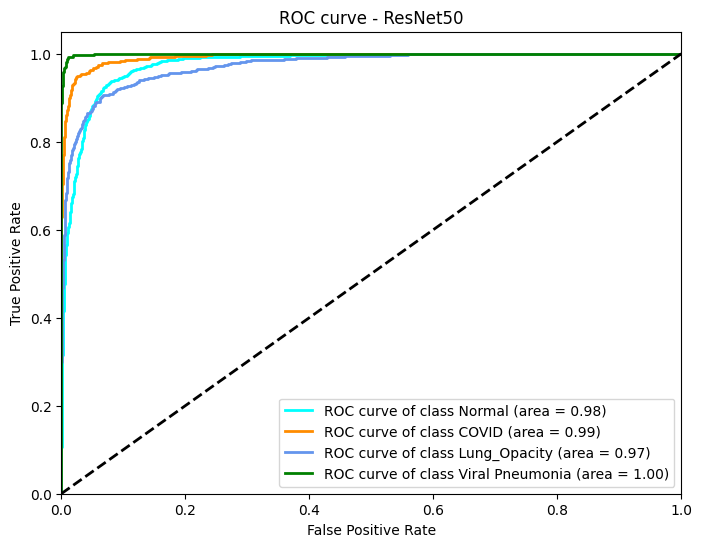

133/133 ━━━━━━━━━━━━━━━━━━━━ 70s 525ms/step


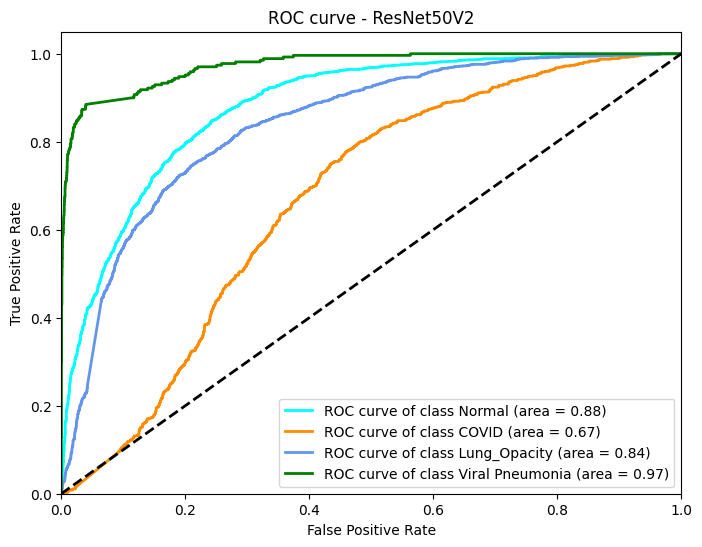

In [34]:
# One vs rest ROC curves for the models

import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

def plot_multiclass_roc(y_true, y_pred, model_name, n_classes = 4):
    # Binarize the true labels
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
    for i, color in zip(range(n_classes), colors):
        label_name = decode_labels(i)
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
            label=f'ROC curve of class {label_name} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2) # random predictions
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(f'ROC curve - {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()


y_pred_resnet50_proba = model_resnet50.predict(X_test)
plot_multiclass_roc(y_test, y_pred_resnet50_proba, 'ResNet50')

y_pred_resnet50v2_proba = model_resnet50v2.predict(X_test)
plot_multiclass_roc(y_test, y_pred_resnet50v2_proba, 'ResNet50V2')